<a href="https://colab.research.google.com/github/monimoreno2905/Parcial1-IA/blob/main/ParcialPunto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. SE IMPORTAN LOS CÓDIGOS Y SE CARGAN LAS LIBRERIAS NECESARIAS PARA EL PROCESO

1.1. Clonar repositorio github para importar keras-vis

tf-keras-vis es una herramientas que permite visualizar internamente como se están comportando las redes neuronales convolucionales al realizar una determinada tarea sobre un cierto conjunto de datos. Este paquete será útil para más adelante usar el método gradcam++ sobre la dataset fashion m-nist.

In [ ]:
# Clone the repository
!git clone https://github.com/keisen/tf-keras-vis.git
# Navigate to the cloned directory
%cd tf-keras-vis
# Install the package in editable mode with development dependencies and TensorFlow
!pip install -e .[develop] tensorflow

Cloning into 'tf-keras-vis'...
remote: Enumerating objects: 2335, done.
remote: Counting objects: 100% (606/606), done.
remote: Compressing objects: 100% (217/217), done.
remote: Total 2335 (delta 355), reused 553 (delta 346), pack-reused 1729
Receiving objects: 100% (2335/2335), 91.77 MiB | 27.68 MiB/s, done.
Resolving deltas: 100% (1370/1370), done.
/content/tf-keras-vis/tf-keras-vis
Obtaining file:///content/tf-keras-vis/tf-keras-vis
  Preparing metadata (setup.py) ... done
  Attempting uninstall: tf-keras-vis
    Found existing installation: tf-keras-vis 0.8.7
    Uninstalling tf-keras-vis-0.8.7:
      Successfully uninstalled tf-keras-vis-0.8.7
  Running setup.py develop for tf-keras-vis


1.2. Importar librerias

Las librerias que se importan se utilizan en general en todo el proceso, por ejemplo para la clasificación, para la visualización, etc.

In [ ]:
#estas dos líneas permiten importar automáticamente los cambios que se hagan en modúlos externos de python
%reload_ext autoreload
%autoreload 2

#En este ejercicio básicamente esta libreria se utilizará para definir arreglos
import numpy as np
#En este ejercicio estas dos librerias se importan para realizar gráficos en el entorno de colab
from matplotlib import pyplot as plt
%matplotlib inline

#Las siguientes librerias permiten en resumen crear y entrenar modelos de redes neuronales
import tensorflow as tf
from tensorflow.keras import layers, losses, Model #se importan argumentos útiles para definir los modelos
from tensorflow.keras.datasets import fashion_mnist #importa la base de datos sobre la cual se va a hacer el análisis
from sklearn.metrics import mean_squared_error #función de perdida entre datos originales y clasificados y/o reconstruidos
from tensorflow.keras.layers import Input, Flatten, Dense, Reshape, Conv2D, MaxPooling2D #se importan capas para construir el modelo

#Esta libreria permite realizar un preprocesamiento a los datos, como por ejemplo, normalización, conversión de espacio de color, etc
from tensorflow.keras.applications.vgg16 import preprocess_input
#Esta libreria se utiliza para convertir la activación a la salida de una neurona en lineal
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
#Esta libreria permite asignar puntajes a las clases de la base de datos para luego ser utilizados en técnicas de visualización
from tf_keras_vis.utils.scores import CategoricalScore

from tf_keras_vis.gradcam_plus_plus import GradcamPlusPlus #importa el método de visualización gradcamplusplus
from matplotlib import cm #es una libreria para los graficos, genera mapas de colores

#Esta libreria permite saber cuántas gpu se detectaron en el sistema
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 0 GPUs


2. CARGAR LOS DATOS QUE VAN A USARSE

2.1. Se carga la base de datos fashion mnist que dispone de imágenes de prendas, dichas imágenes están en escala de grises y tienen un tamaño de 28x28 píxeles. Hay 10 clases diferentes.

In [ ]:
# Cargar y preparar la base de datos
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
x_train = X_train.astype('float32') / 255
x_test = X_test.astype('float32') / 255

# Crea conjuntos de entrenamiento, test y validación para las pruebas que se harán más adelante
x_val = x_train[50000:]
y_val = y_train[50000:]

x_train = x_train[:50000]
y_train = y_train[:50000]

x_train = x_train[..., tf.newaxis]
x_val = x_val[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

y_test=y_test[:50000]

2.2. Se seleccionan tres clases (bota, camisa, zapatilla). Esto se hace con el fin de más adelante visualizar el comportamiento del método grad cam++ sobre estos elementos en especifico.

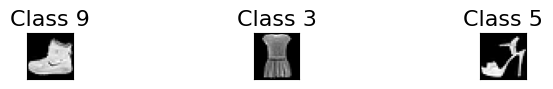

In [ ]:
#Vals contiene indices de los elementos de las tres clases a analizar
#Se debe procurar seleccionar diferentes clases
vals = [0, 3, 9]

# Titulos de las imágenes en las gráficas
image_titles = ['Class '+str(y_train[vals[0]]), 'Class '+str(y_train[vals[1]]), 'Class '+str(y_train[vals[2]])]

# Seleccionar las imágenes
img1 = X_train[vals[0]]
img2=X_train[vals[1]]
img3=X_train[vals[2]]
images = np.array([img1, img2, img3])

#Se aplica un preprocesamiento a las imágenes para que sea legible al producir los mapas de activación
#Este preproceso podría ser normalización
X = preprocess_input(images)

# Gráfica de las imágenes seleccionadas
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(8,1)) #tamaño de la figura y organización (3 columnas, 1 fila)
for i, title in enumerate(image_titles):
    ax[i].set_title(title, fontsize=16) #Coloca como titulo la clase de la imagen
    ax[i].imshow(images[i],cmap='gray') #escala de grises
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.tight_layout() #ajustar espcaciado
plt.show()

3. SE DEFINE EL ENCODER, DECODER Y CLASIFICADOR PARA LA BASE DE DATOS

3.1. El encoder permite convertir la imagen a un espacio de representación menor y su salida pasa al decoder para que este reconstruya las imágenes a su espacio original.

Luego se define un clasificador que permite etiquetar entre las 10 diferentes clases de las imágenes.

Se junta en un solo modelo los tres anteriores de manera que dicho modelo permite reconstruir y clasificar.

En todos los casos se utilizan capas convolucionales que funcionan como filtros de tamaño 3x3. Las funciones de activación en capas intermedias son establecidas en relu y a la salida en softmax. Se diseña el modelo para que este sea funcional y pueda usarse más adelante en la visualización con gradcam++

In [ ]:
# Definir las entradas
inputs = Input(shape=(28, 28,1))
num_classes=10

# Definir el encoder: la arquitectura se estableció empiricamente
encoder_conv1 = Conv2D(32, kernel_size=3, activation='relu', padding='same', name='encoder_conv1')(inputs) #el termino same mantiene el tamaño de la entrada
encoder_pool1 = MaxPooling2D((2, 2), padding='same',name='encoder_pool1')(encoder_conv1) #reducir el tamaño de los filtros
encoder_conv2 = Conv2D(64, (3, 3), activation='relu', padding='same',name='encoder_conv2')(encoder_pool1)
encoder_pool2 = MaxPooling2D((2, 2), padding='same',name='encoder_pool2')(encoder_conv2) #la imagen quedaria de tamaño 14x14

# Definir el decoder: la arquitectura se estableció empiricamente
decoder_conv1 = Conv2D(64, (3, 3), activation='relu', padding='same',name='decoder_conv1')(encoder_pool2) #recibe la salida del encoder
decoder_conv2 = Conv2D(32, (3, 3), activation='relu', padding='same',name='decoder_conv2')(decoder_conv1)
decoder_flatten = Flatten()(decoder_conv2) #Aplana las imágenes para poder pasarlas a la capa densa
decoder_dense = Dense(28*28, activation="relu")(decoder_flatten)
reconstructed_outputs = Reshape([28, 28])(decoder_dense) #imagen original (28x28)

#Definir el clasificador: la arquitectura se estableció empiricamente
x = Conv2D(64, (3, 3), activation='relu', padding='same',name='classifier_conv1')(encoder_pool2) #recibe la salida del encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same',name='classifier_conv2')(x)
x = Conv2D(16, (3, 3), activation='relu', padding='same',name='classifier_conv3')(x)
x=Flatten()(x)
classification_outputs = layers.Dense(num_classes, activation='softmax')(x) #porporciona un vector con las probabilidades de pertencencia a cada clase

# Crear el modelo del autoencoder
autoencoder = Model(inputs, reconstructed_outputs)

# Crear el modelo del clasificador
classifier = Model(inputs, classification_outputs)

# Combinar los modelos de autoencoder y clasificador
combined_outputs = [reconstructed_outputs, classification_outputs]
combined_model = Model(inputs, combined_outputs) #este modelo reconstruye y clasifica

# Compilar el modelo combinado
combined_model.compile(optimizer='adam',
                                     loss=['mse', 'sparse_categorical_crossentropy'],
                                     loss_weights=[0.5, 0.5]  # Los pesos se distribuyen de igual a igual para clasificación y reconstrucción
                                     )

# Entrenar el modelo
combined_model.fit(x_train, [x_train, y_train], epochs=10, batch_size=64, validation_data=(x_val, [x_val, y_val]))

#Reconstrucción y clasificación
prediction=combined_model.predict(x_train) #ofrece dos tuplas (una para reconstrucción y otra para clasificación)
predicted_classes = tf.argmax(prediction[1], axis=1).numpy() #se selecciona la probabilidad más alta dada por la clasificación (asignación de clases)

#error cuadrático medio entre la clasificación y datos originales
mse = mean_squared_error(y_train, predicted_classes)
rmse = np.sqrt(mse)
print(rmse)

Epoch 1/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 289s 363ms/step - loss: 0.3911 - val_loss: 0.1943
Epoch 2/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 276s 354ms/step - loss: 0.1708 - val_loss: 0.1543
Epoch 3/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 340s 378ms/step - loss: 0.1414 - val_loss: 0.1470
Epoch 4/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 311s 365ms/step - loss: 0.1294 - val_loss: 0.1366
Epoch 5/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 307s 347ms/step - loss: 0.1176 - val_loss: 0.1271
Epoch 6/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 332s 360ms/step - loss: 0.1073 - val_loss: 0.1263
Epoch 7/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 308s 342ms/step - loss: 0.0976 - val_loss: 0.1253
Epoch 8/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 276s 353ms/step - loss: 0.0905 - val_loss: 0.1275
Epoch 9/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 326s 358ms/step - loss: 0.0843 - val_loss: 0.1224
Epoch 10/10
782/782 ━━━━━━━━━━━━━━━━━━━━ 330s 368ms/step - loss: 0.0740 - val_loss: 0.1218
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 99s 63ms/step
0.73589401410801


Con respecto a la clasificación se puede observar que al realizar el entrenamiento, la perdida va disminuyendo conforme las épocas aumentan pero al realizar la medida de MSE sobre el conjunto total de datos este tiene un valor alto. Como conclusión habría un sobreentrenamiento que deberia mejorarse modificando parámetros y estructura del modelo

3.2. Gráfica resultados de reconstrucción

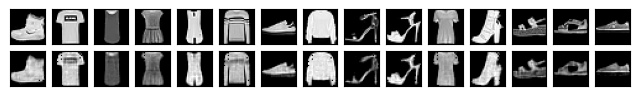

In [ ]:
#Esta función se usará para graficar datos reales vs reconstruidos
#x datos reales, xpred datos predichos
def plot_mnist_autoencoder(x,xpred,cmap='gray',vmin=0,vmax=1):
  fig,ax = plt.subplots(2,x.shape[0],figsize=(8,1)) #Organización en dos filas
  for i,class_ in enumerate(range(x.shape[0])): #el ciclo se hace dependiendo de las imágenes que se quiere graficar
        ax[0,i].imshow(x[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([]) #esta primera parte grafica datos reales

        ax[1,i].imshow(xpred[i],cmap=cmap,vmin=vmin,vmax=vmax)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([]) #esta segunda parte grafica datos reocnstruidos
  plt.show()
  return

#Graficar reconstrucciones vs datos originales
plot_mnist_autoencoder(x_train[:15],prediction[0][:15])

Con respecto a la reconstrucción, la imagen muestra que al parecer esta se hace de mejor manera que la clasificación pese a que se les dio prioridad del 50/50. El problema seguramente se debe a que la estructura de las redes es más compleja para los encoders y decoders

4. VISUALIZACIÓN CAPAS GRADCAM++

4.1. Función Grad cam++

El método es una versión mejorada de grad cam que permite destacar visualmente que zonas de una imagen son importantes para la predicción de una determinada clase. Lo anterior puede ayudar a mejorar el modelo para que este converja más rápido. El proceso que se realiza es el siguiente:

* Se clasifica la imagen con el modelo definido

* Se calcula el gradiente de la clase que se está analizando (Los gradientes son vectores que indican la tasa de cambio de la salida de la red neuronal con respecto a las activaciones de una capa convolucional).

* Se calculan pesos por cada filtro de la CNN teniendo en cuenta los resultados de los gradientes y los valores de los filtros en cada posición i,j. Para el calculo de los pesos se aplica la función RELU sobre el gradiente de la clase objetivo con respecto a la activación en la posición i,j de un definido canal.

* ReLU se aplica para mantener solo los valores positivos, eliminando las influencias negativas y resaltando las regiones importantes.

* Finalmente el mapa producido se puede superponer a la imagen para resaltar áreas de intéres.

* El proceso solo se puede aplicar a capas CNN porque mantienen una estructura similar a la de las imágenes.

In [ ]:
#Esta función permite reemplazar a lineal la salida de una determinada neurona. Esto se hace porque
#facilita el calculo del gradiente en el método gradcam, las funciones no lineales podrían tener problemas
#cuando el gradiente sea cero (saturación). Las derivadas de algo lineal son cero, lo que facilita los
#calculos de los gradientes.

replace2linear = ReplaceToLinear()

#La siguiente función permite  aplicar el método gradcam++, se necesita ingresarle a la función:
#el modelo clasificador, los datos a visualizar y el nombre de la capa a visualizar

def generate_and_visualize_gradcam(classifier, X, name_layer):
    # Crea GradCAM++ object
    gradcam = GradcamPlusPlus(classifier,#modelo del clasificador
                              model_modifier=replace2linear, #reemplaza salidas no lineales por lineales para que sean más compatibles con el modelo
                              clone=True)#se clona el modelo original para evitar modificaciones permanentes sobre este

    # Expandir dimensiones si es necesario, esto se hace para que las imágenes sean compatibles con el clasificador
    if X.ndim == 3:
        X = np.expand_dims(X, axis=-1)

    #Variables
    lcam_= [] #Contiene los mapas de activación por cada imagen
    #lcamN_= [] #Mapa de activación normalizado
    vnorm = np.zeros((X.shape[0],10)) #Matriz que contiene la normalización de los mapas de cada imagen por cada clase
    Pp = X.shape[1]*X.shape[2] #Tamaño total de la imagen
    # Genera mapa de calor, aquí se especifica el nombre de la capa a visualizar
    for j in range(10):
        score =  CategoricalScore(j)#Genera una etiqueta para saber con respecto a que clase se esta generando el mapa de activación
        lcam_ += [gradcam(score,
                            X,  normalize_cam = False, #normalize
                            penultimate_layer=name_layer
                          )]

        vnorm[:,j] = 1/Pp*(lcam_[j].reshape(X.shape[0],-1)).dot(np.ones(Pp))  #La normalización se hace para que los mapas sean comparables

    return vnorm,lcam_,

4.2. Funciones para la visualización de resultados

In [ ]:
# Función para graficar los mapas de activación sobre las imágenes
def graphcams(lcam,images,vals):
  A=y_train[vals] #se obtienen las clases de los tres elementos seleccionados
  indices = [(A[0], 0), (A[1], 1), (A[2], 2)] #No se deben graficar todos los mapas, solo los de las clases seleccionadas y solo las tres imágenes
  f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4)) #Se organiza la grafica en tres columnas y una fila
  for j, i in indices:
      heatmap = np.uint8(cm.jet(lcam[j][i])[..., :3] * 255)
      ax[i].set_title(image_titles[i], fontsize=16)
      ax[i].imshow(images[i])
      ax[i].imshow(heatmap, cmap='jet', alpha=0.5)
      ax[i].axis('off')
  plt.tight_layout()
  plt.show()

In [ ]:
#Esta función permite analizar de forma gráfica la matriz vnorm. Cada fila de la matriz representa una distribución de probabilidad.
#El color amarillo representa un valor más cercano a uno mientras que los azules un valor cercano a cero.
def matriz(vnorm,y_test):
  ind = np.argsort(y_test) #Ordena los indices en orden ascendente de las etiquetas
  vnorm = vnorm/(vnorm.sum(axis=1).reshape(-1,1)+1e-10)

  plt.pcolormesh(vnorm[ind],vmin=0,vmax=1) #normaliza vnorm en el rango de 0 a 1
  plt.colorbar()
  plt.show()

In [ ]:
#Libreria para la segmentación de imágenes
from skimage import segmentation
#Libreria para la generación de mapas de colores
import matplotlib.cm as cm
#herramientas para crear y posicionar elementos gráficos adicionales de una grafica
from matplotlib.offsetbox import AnnotationBbox, OffsetImage
#Libreria para visualización de imágenes
import matplotlib as mpl
#Libreria para procesar imágenes
from PIL import Image,ImageOps

#A continuación se definen dos funciones que permiten graficar los elementos del conjunto de datos en 2D.
#La grafica se hace de forma que los elementos se ordenen por grupos. A diferencia de la primera,
#la segunda gráfica tiene también en cuenta los mapas de activación por clase. Si la clasificación es buena,
#la grafica generada en la segunda función deberia resaltar la clase que se está clasificando

"""Los parametros que se ingresan a la función son:
X: Matriz de características (imágenes 28x28).
y: Etiquetas de las clases.
min_distance: Distancia mínima entre puntos para mostrar una imagen (para evitar superponer datos).
zoom: Factor de zoom para las imágenes superpuestas.
images: Conjunto de imágenes correspondientes a los datos en X.
figsize: Tamaño de la figura del gráfico.
s: Tamaño de los puntos en el gráfico.
cmap: Mapa de colores para las clases.
colorbar: Posición de la barra de colores ('right' o 'left')"""

def plot_digits(X, y, min_distance=0.01, zoom=0.5,images=None, figsize=(10, 10),s=10,cmap='jet',colorbar='right'):
    # Escalar los datos entre 0 y 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Coordenadas de los datos, se van agregando para formar los grupos
    neighbors = np.array([[10., 10.]])
    fig = plt.figure(figsize=figsize)

    #etiquetas diferentes en los datos
    digits = np.unique(y)
    #Grafica de los datos teniendo en cuenta dos características
    im_ = plt.scatter(X_normalized[:, 0], X_normalized[:, 1],c=y, cmap=cmap,s=s)
    ax = plt.gcf().gca()
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_facecolor((0.1,0.1,0.1,0.25))
    #Este ciclo se hace para calcular la distancia entre las imágenes y evitar que se superpongan
    for index, image_coord in enumerate(X_normalized):
        #Distancia más cercana entre el punto actual y los puntos ya graficados
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:  #verificar si el punto actual esta lo suficientemente lejos de los ya graficados
            neighbors = np.r_[neighbors, [image_coord]] #Actualizar las coordenadas de los puntos ya graficados
            if images.all() != None: #Verificar que el grafico no este vacio
                image = images[index].reshape(28, 28) #redimensionar la imagen
                #crear una representación de la imagen incrustada (utilizando OffsetImage)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary",
                                                      zoom=zoom,alpha=0.6),
                                           image_coord,xycoords='data', frameon=False)
                ax.add_artist(imagebox)
                ax.autoscale()
        unv = np.unique(y) #Extrae las etiquetas y junto con la barra de colores se representa cada clase con un color diferente
      #Ubicación de la barra de colores y grafica de los resultados
    if colorbar == 'right':
      cax = fig.add_axes([0.915, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))

    elif colorbar == 'left':
      cax = fig.add_axes([0.085, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))
      cax.yaxis.tick_left()

In [ ]:
"""Parámetros de la función
X: Datos de entrada (imágenes).
y: Etiquetas de los datos de entrada.
s: Tamaño de los puntos en el gráfico.
Cams: Mapas de activación de Grad-CAM para cada imagen.
images: Imágenes originales de Fashion MNIST.
NN: Indicador de si se deben colocar las imágenes basándose en la distancia mínima entre vecinos.
min_distance: Distancia mínima entre imágenes para ser colocadas en el gráfico.
zoom: Factor de zoom para las imágenes superpuestas.
figsize: Tamaño de la figura.
max_c: Número máximo de imágenes a superponer basándose en s.
spercentile: Percentil de s para decidir qué imágenes superponer.
cmap: Mapa de colores para los puntos.
colorbar: Posición de la barra de color ('right' o 'left')."""
def plot_digits_AM(X, y, s,Cams,images,NN=False,min_distance=0.01,zoom=0.5,figsize=(10, 10),max_c = 100,spercentile=90,cmap='jet',colorbar='right'):    # Normalizar los datos entre cero y uno
    X_normalized = MinMaxScaler().fit_transform(X)
    # Coordenadas de los digitos
    neighbors = np.array([[10., 10.]])
    # Tamaño de la grafica
    fig = plt.figure(figsize=figsize)
    #Etiquetas diferentes de los datos
    digits = np.unique(y)
    #Toma solo dos caracteristicas para graficar puntos
    im_ = plt.scatter(X_normalized[:, 0], X_normalized[:, 1],c=y, cmap=cmap,s=s)
    ax = plt.gcf().gca()  # get current axes in current figure
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_facecolor((0.1,0.1,0.1,0.25))
    ax = plt.gcf().gca()


    #plotting according to L2 distance
    if NN:
      for index, image_coord in enumerate(X_normalized):
          closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
          if closest_distance > min_distance:
              heatmap = Image.fromarray(np.uint8(cm.jet(Cams[index])[..., :3] * 255)).convert('L')
              heatmap = ImageOps.colorize(heatmap, black ="white", white ="red")


              neighbors = np.r_[neighbors, [image_coord]]
              image = images[index].reshape(28, 28)
              imagebox = AnnotationBbox(OffsetImage(image, cmap="binary",zoom=zoom,alpha=0.7), image_coord,xycoords='data', frameon=False)
              ax.add_artist(imagebox)
              im = OffsetImage(heatmap,zoom=zoom,alpha=0.6)

              imagebox = AnnotationBbox(im, image_coord,xycoords='data', frameon=False)
              ax.add_artist(imagebox)
              ax.autoscale()
    #Graficar de acuerdo a la cantidad de imágenes posible que se puede superponer
    sper = np.percentile(s,spercentile)
    inds = np.arange(len(s))[s>sper]
    if len(inds) > max_c: inds = inds[:max_c]

    for index in inds:
      #Mapa de activación
      heatmap = Image.fromarray(np.uint8(cm.jet(Cams[index])[..., :3] * 255)).convert('L')
      heatmap = ImageOps.colorize(heatmap, black ="white", white ="red")
      #reshape de la imagen
      image = images[index].reshape(28, 28)
      #Crear una representación de la imagen incrustada (utilizando OffsetImage)
      imagebox = AnnotationBbox(OffsetImage(image, cmap="binary",zoom=zoom,alpha=0.7), X_normalized[index],xycoords='data', frameon=False)
      ax.add_artist(imagebox)
      im = OffsetImage(heatmap,zoom=zoom,alpha=0.6)
      imagebox = AnnotationBbox(im, X_normalized[index],xycoords='data', frameon=False)
      ax.add_artist(imagebox)
      ax.autoscale()
    #Extrae las etiquetas y junto con la barra de colores se representa cada clase con un color diferente
    unv = np.unique(y)
    #Ubicación de la barra de colores y grafica de los resultados
    if colorbar == 'right':
      cax = fig.add_axes([0.915, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))

    elif colorbar == 'left':
      cax = fig.add_axes([0.085, 0.125, 0.015,0.75])
      if len(unv)<= 10: plt.colorbar(im_, cax=cax,ticks=list(unv))
      else: plt.colorbar(im_, cax=cax,ticks=list(np.linspace(min(unv),max(unv),10).round(2)))
      cax.yaxis.tick_left()

5. PRUEBAS

5.1. Prueba 1: Capa convolucional 1

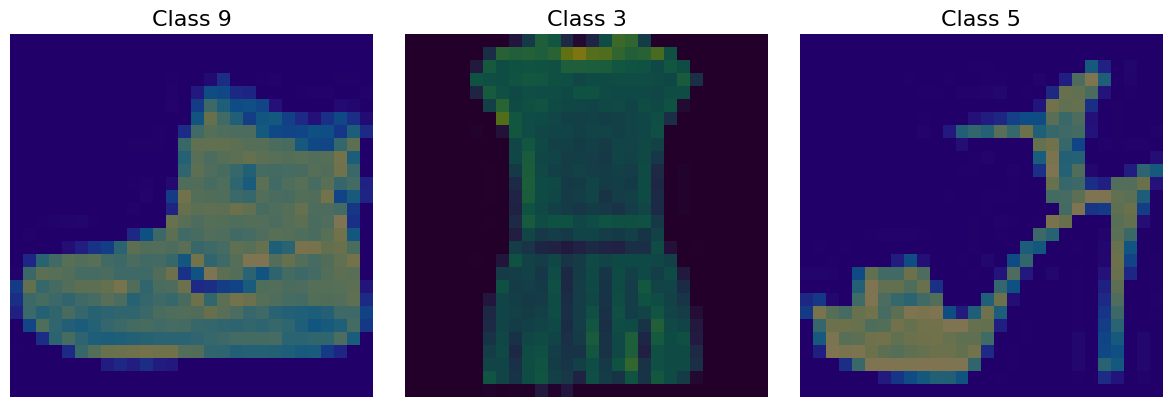

In [ ]:
#Se aplica la función 4.1 al cojunto de las tres imágenes seleccionadas en el paso 2.2
#La prueba se hizo sobre la primera capa convolucional
vnorm0,lcam0 =generate_and_visualize_gradcam(classifier, X, 'classifier_conv1')
graphcams(lcam0,images,vals)

Teniendo en cuenta los parámetros establecidos en el código, las regiones amarillas representan mayor activación y las azules menor.

De acuerdo a lo anterior, se puede observar que en la primera y tercera imagen se resaltan más zonas de activación en comparación con la segunda. Se podría decir que para la novena y quinta clase se hacen necesarios casi todos los elementos de la imagen para poder diferenciarlas.

En cambio en la tercera clase es suficiente con solo algunos puntos de la imagen. Especialmente se resaltan los bordes y es que estos permiten determinar las formas presentes en la imagen

El fondo de las imágenes no representa algo contributivo y esto se confirma al observar el color azul del mapa.

A partir de la visualización podria concluir que la clasificación de la clase 3 se hará mejor que para la clase 9 y 5 porque no se necesitan tantos elementos para llevar a cabo el proceso.

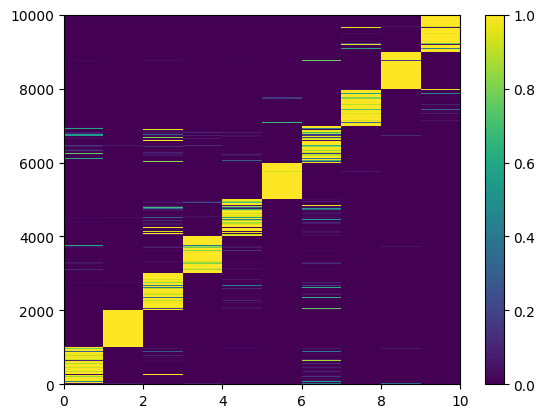

In [ ]:
#Generación de los mapas de activación (función 4.1), esta vez sobre el conjunto total de datos
vnormA,lcam_A =generate_and_visualize_gradcam(classifier, x_test, 'classifier_conv1')
#Grafica de la matriz vnorm
matriz(vnormA,y_test)

Según esta gráfica, al parecer la clase 6 es la que mejor está clasificada porque los datos tienden a distribuirse a lo largo de todo el conjunto. Por otro lado la clase 5 es la que peor está claisificada porque los datos tienden a concentrarse en un solo espacio. Viendo las etiquetas verdaderas (y_test) la clase 5 está distribuida a lo largo de todos los datos.


5.2. Prueba 2 (capa convolucional 2)

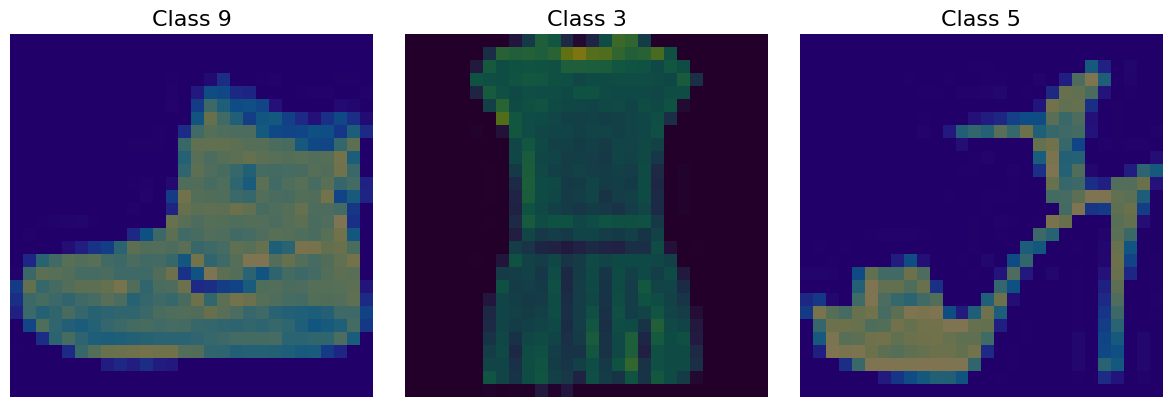

In [ ]:
#Se aplica la función 4.1 al conjunto de las tres imágenes seleccionadas en el paso 2.2
#La prueba esta vez se hizo sobre la segunda capa convolucional
vnorm1,lcam1 =generate_and_visualize_gradcam(classifier, X, 'classifier_conv2')
graphcams(lcam1,images,vals)

En esta segunda prueba se observan resultados muy similares a los de la primera. Solo que las regiones amarillas (mayor activación) tienden a ser menores y esto se puede deber a que los mapas que pasaron a la capa 2 desde la capa 1 extraen los detalles más importantes.

In [ ]:
#Generación de los mapas de activación (función 4.1), esta vez sobre el conjunto total de datos
vnormB,lcamB =generate_and_visualize_gradcam(classifier, x_test, 'classifier_conv2')

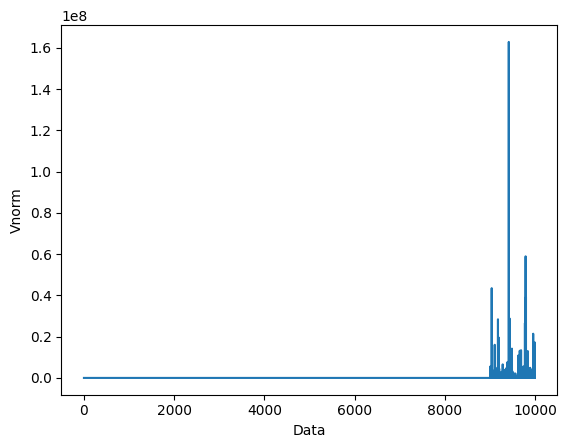

In [ ]:
c=9 #Clase que quiere observarse
ind = np.argsort(y_test) #Ordena los indices en orden ascendente de las etiquetas
plt.plot(vnormB[ind,c]) #Se grafica para una única clase los resultados de gradcam
plt.xlabel('Data')
plt.ylabel('Vnorm')
plt.show()

En la anterior grafica, si la clasificación es eficiente las barras deberian resaltarse más en los valores donde y_test es igual a la clase 9. Según los resultados obtenidos se puede observar que únicamente está tomando los últimos datos como de la clase 9. Sin embargo, hay datos de la novena clase distribuidos alrededor de todo el conjunto, pero estos no son visualizados sugiriendo que la clasificación debería mejorarse.

5.3. Prueba 3 (capa convolucional 3)

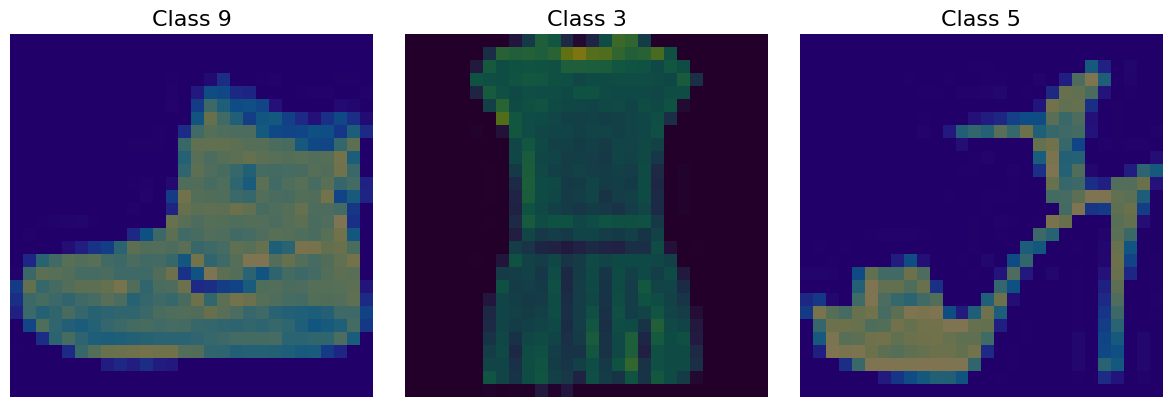

In [ ]:
#Se aplica la función 4.1 al cojunto de las tres imágenes seleccionadas en el paso 2.2
#La prueba esta vez se hizo sobre la tercera capa convolucional
vnorm1,lcam1 =generate_and_visualize_gradcam(classifier, X, 'classifier_conv3')
graphcams(lcam1,images,vals)

En la capa final del clasificador se puede observar que los resultados no varían significativamente con respecto a los de la capa 2. Esto se puede deber a que la estructura de las capas es similar con respecto al tamaño de filtros y otros parametros.

In [ ]:
#Generación de los mapas de activación (función 4.1), esta vez a la totalidad de los datos
vnormC,lcamC =generate_and_visualize_gradcam(classifier, x_test, 'classifier_conv3')

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 52ms/step


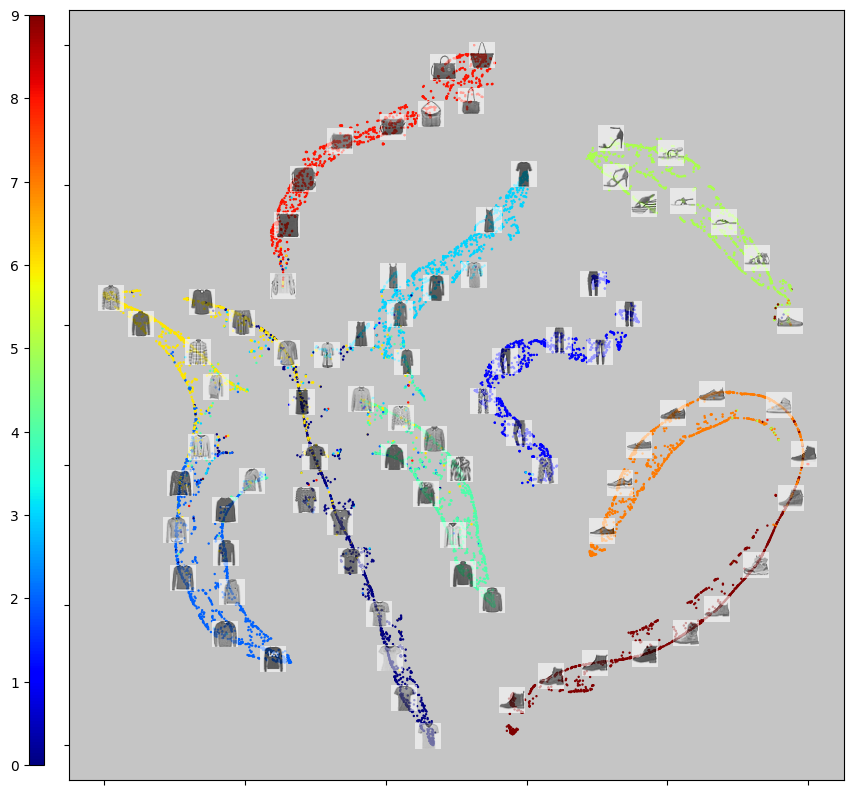

In [ ]:
#Con la finalidad de observar los resultados en dos dimensiones se aplica el método TSNE

#importa t-Distributed Stochastic Neighbor Embedding que es un algoritmo no lineal
#que se base en calculos probabilisticos para realizar la reducción de dimensión
from sklearn.manifold import TSNE
#Librera para escalar las características entre cero y uno
from sklearn.preprocessing import MinMaxScaler

#modelo del clasificados
model=classifier
#Se llama a minmaxscales
sca_r = MinMaxScaler()
#Se define el elemento TSNE. perplexity controla la cantidad de vecinos cercanos
#Se inicializa el método con PCA
red_r = TSNE(n_components=2,perplexity=50,learning_rate='auto',init='pca',random_state=123)
#Datos reducidos sobre las predicciones hechas con el clasificador
ztsne = red_r.fit_transform(sca_r.fit_transform(model.predict(x_test)))
#Grafica de los datos con la tercera función de la sección 4.2
plot_digits(ztsne, y_test, min_distance=0.055, zoom= 0.65, images=x_test,s=0.5,
            colorbar ='left') #mnist samples
plt.show()

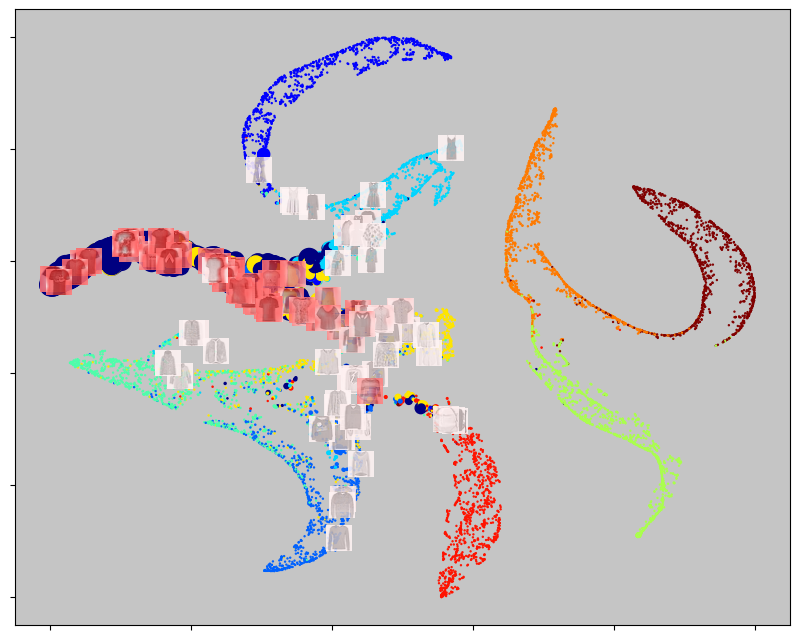

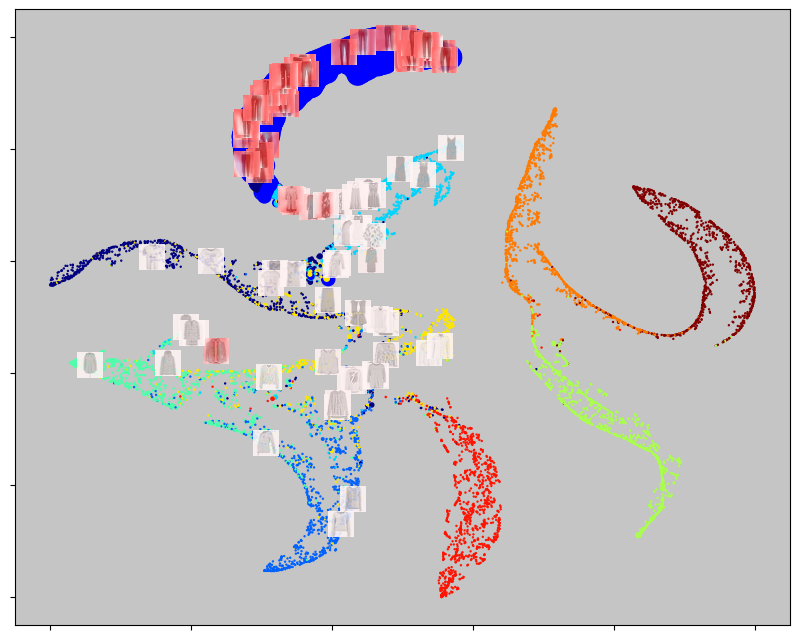

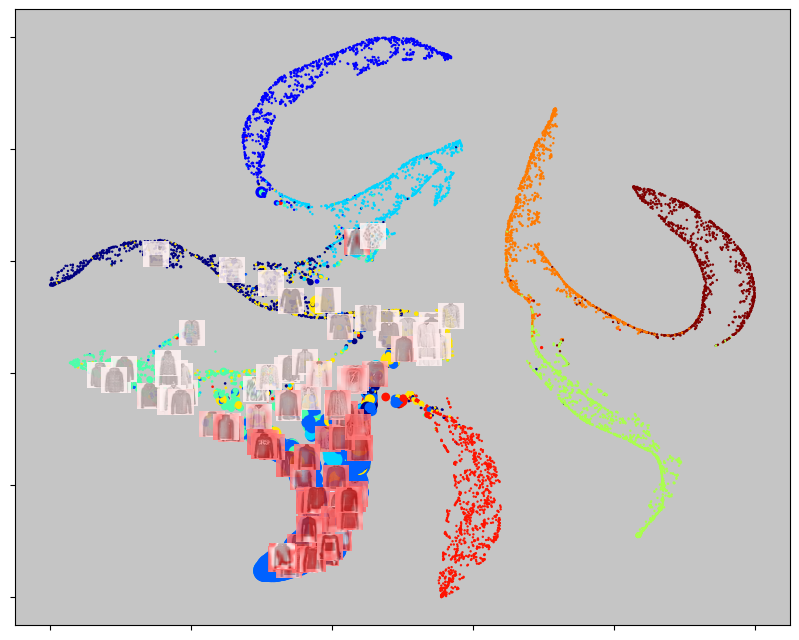

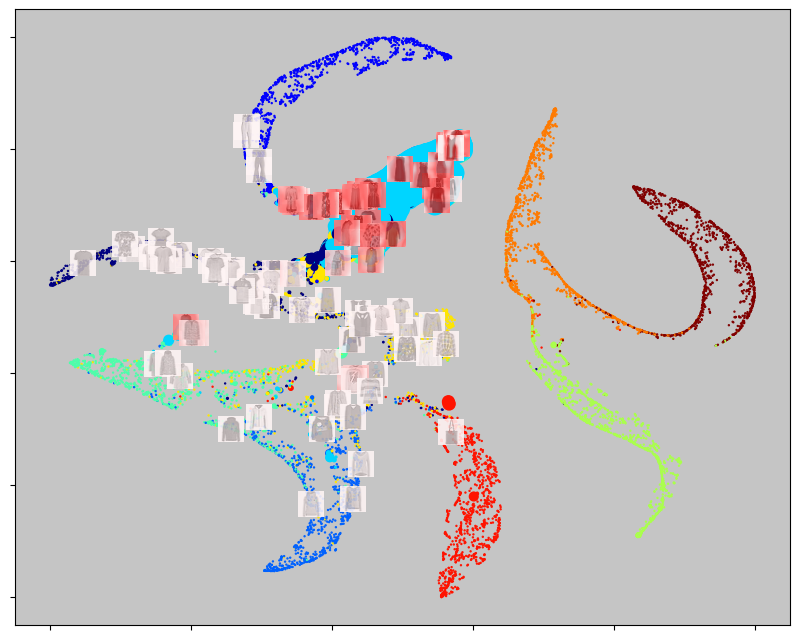

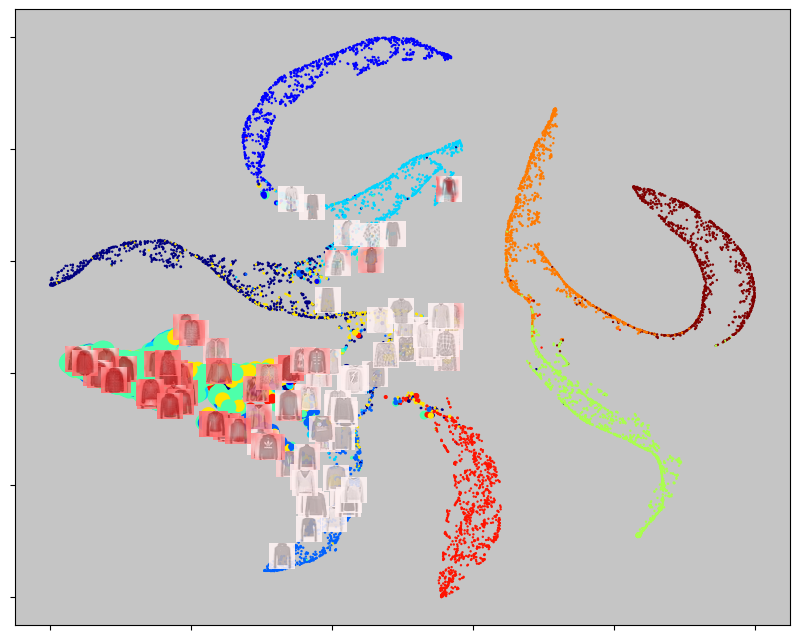

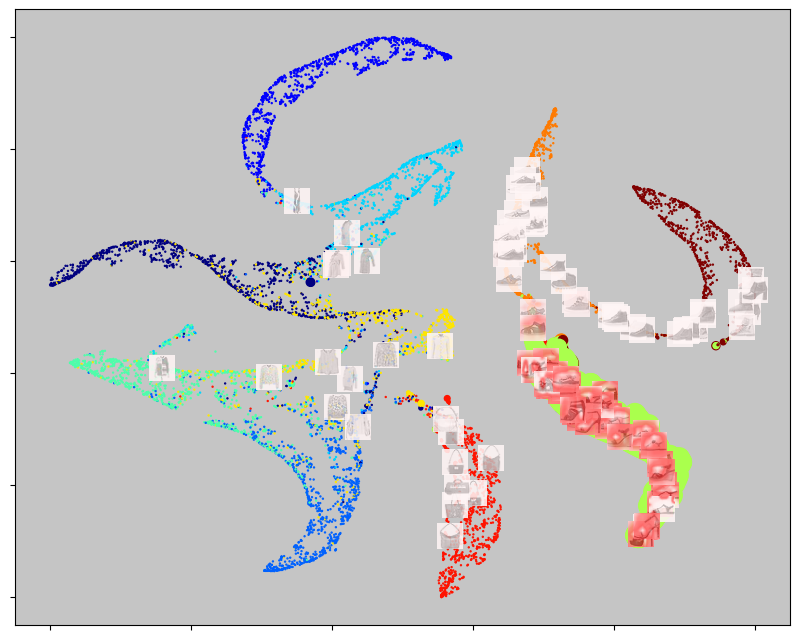

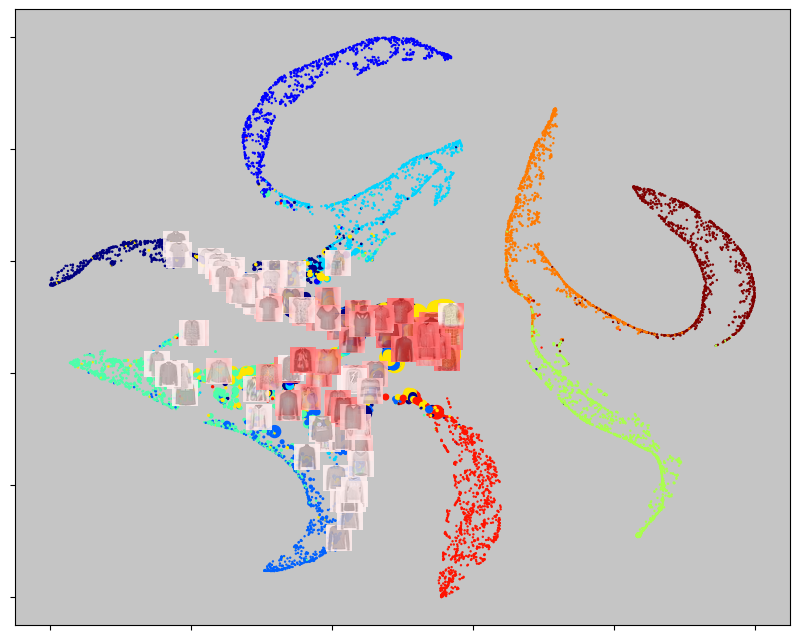

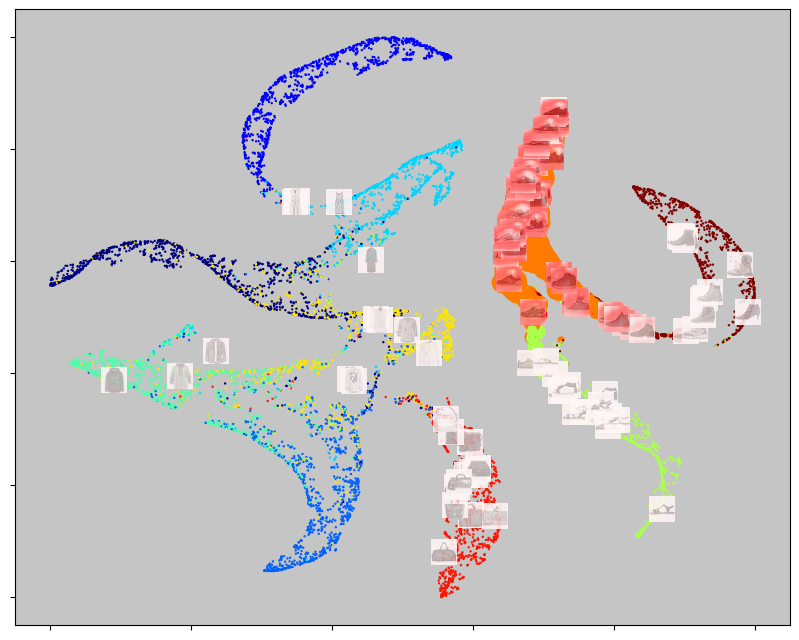

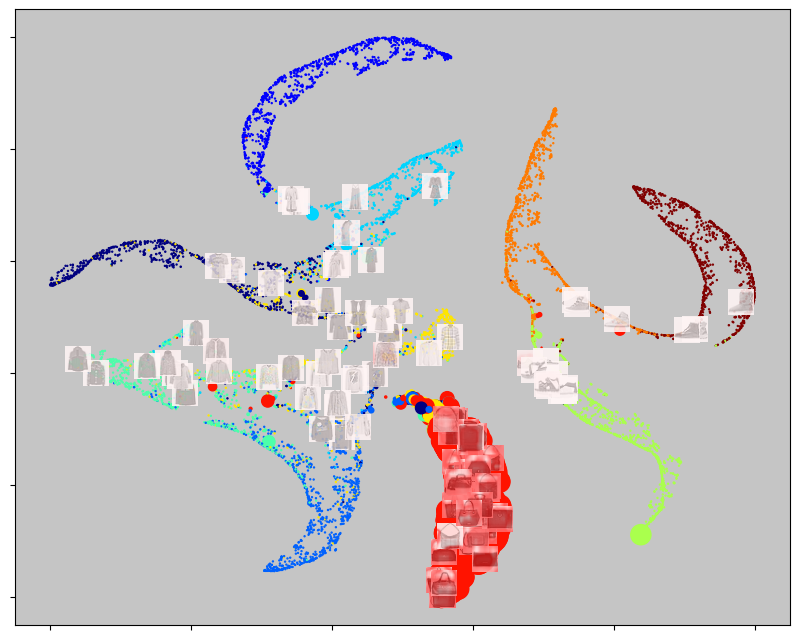

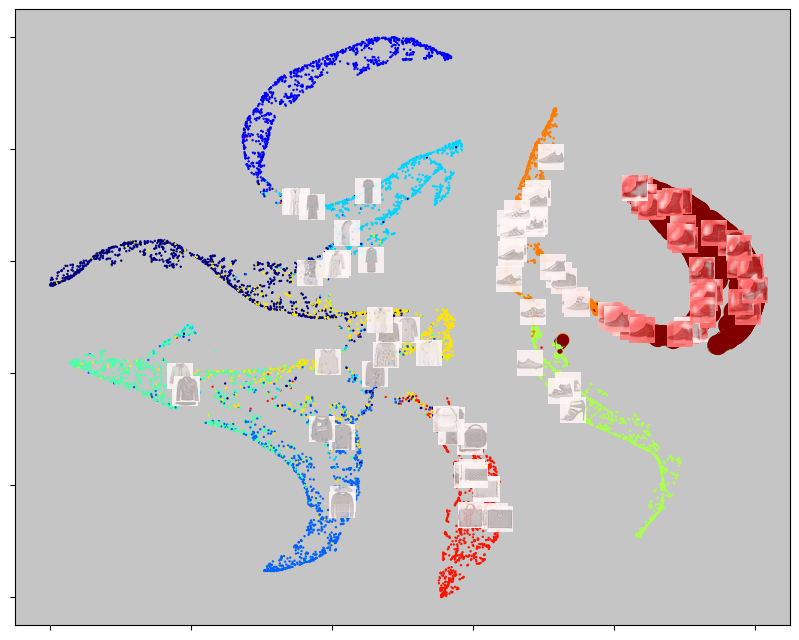

In [ ]:
#Ahora se utiliza la cuarta función de la sección 4.2 para graficar las activaciones de la clase i con respecto a todas las clases
K=10 #Número de clases
figsize = (10, 8) #Tamaño de la figura
for jj in range(K):
    sc = (15*vnormC[:,jj])**2+0.5
    plot_digits_AM(ztsne, y_test,s=sc,Cams=lcamN_[jj],images=x_test,min_distance=0.055,zoom=0.65,
               figsize=figsize,spercentile = 75,max_c=100,colorbar=None,NN=False)
    plt.show()

De acuerdo a la grafica anterior, se puede observar que las clases tienden a ser confundidas con otras. Por ejemplo, en la clase 9 en su mayoria se realtan sacos, cuando en su mayoria deberian resaltarse zapatos. Aasí mismo se resaltan faldas y otros elementos que no pertencen a la clase 9.

6. Prueba y conclusión final

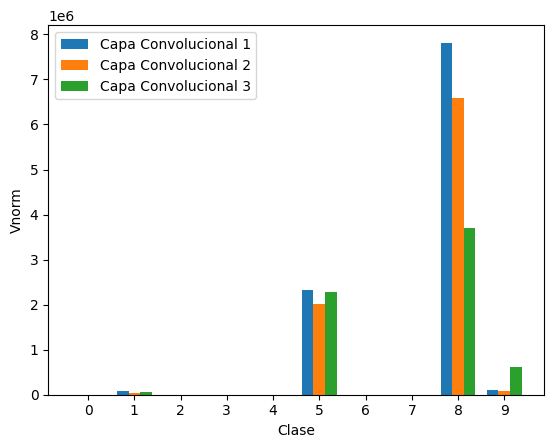

In [ ]:
#Se sacan los promedios por capa convolucional para cada clase
promediosA = np.mean(vnormA, axis=0)
promediosB = np.mean(vnormB, axis=0)
promediosC = np.mean(vnormC, axis=0)

# Crear un array con los índices para las barras
indices = np.arange(10)

# Definir el ancho de las barras
width = 0.25

# Crear el gráfico
fig, ax = plt.subplots()

# Graficar cada grupo de barras
ax.bar(indices - width, promediosA, width, label='Capa Convolucional 1')
ax.bar(indices, promediosB, width, label='Capa Convolucional 2')
ax.bar(indices + width, promediosC, width, label='Capa Convolucional 3')

# Añadir etiquetas y título
ax.set_xlabel('Clase')
ax.set_ylabel('Vnorm')
ax.set_xticks(indices)
ax.legend()

# Mostrar el gráfico
plt.show()

En la gráfica puede observarse como cada capa convolucional influye sobre una determinada clase. Según la gráfica para todas las capas no hay una buena activación para la mayoria de las clases. Las capas únicamente están contribuyendo en la clasificación de la clase, 9 y mayormente para la clase 8.